In [79]:
import random
import copy
import numpy as np

class Connect4:
    def __init__(self):
        self.state = np.zeros((6, 7), dtype=int)
        self.game_over = False
        self.current_player = 1 

    def display_board(self):
        board = np.where(self.state == 1, 'X', np.where(self.state == -1, 'O', ' '))

        for row in board:
            print('|' + '|'.join(row) + '|')
        
        print('+-' * 7 + '+')

    def get_legal_moves(self, state):
        return [col for col in range(7) if state[0][col] == 0]

    def drop_piece(self, column, player):
        if not 0 <= column < 7 or self.state[0][column] != 0:
            return False

        for row in range(5, -1, -1):
            if self.state[row][column] == 0:
                self.state[row][column] = player
                
                # Check for win or full board (top row)
                if (
                    self.check_winner() != 0 
                    or not np.any(self.state[0] == 0)
                ):
                    self.game_over = True
                return True
        return False

    def check_winner(self):
        for row in range(6):
            for col in range(7):
                if self.state[row][col] != 0:
                    if self.check_line(row, col, 1, 0) or \
                       self.check_line(row, col, 0, 1) or \
                       self.check_line(row, col, 1, 1) or \
                       self.check_line(row, col, 1, -1):
                        return self.state[row][col]
        return 0

    def check_line(self, start_row, start_col, d_row, d_col):
        for i in range(1, 4):
            r = start_row + d_row * i
            c = start_col + d_col * i
            if (
                not (0 <= r < 6 and 0 <= c < 7) 
                or self.state[r][c] != self.state[start_row][start_col]
            ):
                return False
        return True

    def switch_player(self):
        self.current_player = -self.current_player

    def clone(self):
        clone = Connect4()
        clone.state = np.copy(self.state)
        return clone

def play_game():
    game = Connect4()
    mcts = MCTS_Strategy(10, 1)

    while not game.game_over:
        game.display_board()

        if game.current_player == 1:
            # move = strategy_player(game)
            move = mcts.policy(game)
        else:
            move = strategy_random_agent(game) 
            
        game.drop_piece(move, game.current_player)
        
        winner = game.check_winner()
        if winner != 0:
            game.display_board()
            print(f"Player {'X' if winner == 1 else 'O'} wins!")
            break

        # Draw
        if not np.any(game.state[0] == 0):  
            game.display_board()
            print("The game is a draw!")
            break

        game.switch_player()

# Human play against ai ;)
def strategy_player(game):
    valid_move = False
    while not valid_move:
        try:
            column = int(input("Choose a column (0-6): "))
            if column in game.get_legal_moves(game.state):
                valid_move = True
            else:
                print("Invalid move. Try again.")
        except ValueError:
            print("Invalid input. Please enter a number between 0 and 6.")

    return column

def strategy_random_agent(game):
    legal_moves = game.get_legal_moves(game.state)
    if legal_moves:
        return random.choice(legal_moves)
    else:
        return None


play_game()



| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| |X| | | | | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| |X| |O| | | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
|X|X| |O| | | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |O| | | |
|X|X| |O| | | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |O| | | |
|X|X| |O|X| | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |O|O| | |
|X|X| |O|X| | |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |O|O| | |
|X|X| |O|X|X| |
+-+-+-+-+-+-+-+
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | | | | | |
| | | |O|O| | |
|X|X| |O|X|X|O|
+-+-+-+-

In [78]:
class Node:
    def __init__(self, move=None, parent=None):
        self.move = move
        self.parent = parent
        self.children = []
        self.wins = 0
        self.visits = 0

    def is_leaf(self):
        return len(self.children) == 0

    def add_child(self, child_node):
        self.children.append(child_node)

    def update(self, result):
        self.visits += 1
        self.wins += result

    def winrate(self):
        return self.wins / self.visits if self.visits > 0 else 0
    
    # this nodes upper confidence bounds
    def ucb(self, c):
        # prevent divide by zero
        # n_visits = self.visits + 1
        # p_visits = self.parent.visits + 1
        
        if self.visits == 0:
            return float('inf')
        
        exploit = self.wins / n_visits
        explore = c * np.sqrt(np.log(self.parent.visits) / (self.visits))
        return exploit + explore

    def best_move(self):
        return max(self.children, key=lambda child: child.winrate())

    def expand_node(self, game):
        legal_moves = game.get_legal_moves(game.state)
        for move in legal_moves:
            if not any(child.move == move for child in self.children):
                self.add_child(Node(move, self))

# Inspired by: 
# https://webdocs.cs.ualberta.ca/~hayward/396/jem/mcts.html#mcts
class MCTS_Strategy:
    def __init__(self, computation_budget=10, player=1, c=1.3):
        self.computation_budget = computation_budget
        self.player = player
        self.c = c

    def policy(self, game):
        root_node = Node(None, None)

        for _ in range(self.computation_budget):
            game_state = game.clone()
            node = root_node

            # Selection
            while not node.is_leaf():
                if node.move is not None:
                    game_state.drop_piece(node.move, game_state.current_player)
                    game_state.switch_player()
                node = self.tree_policy(node, game_state)

            # Expansion
            node.expand_node(game_state)

            # Simulation
            result = self.simulation_policy(game_state)

            # Backpropagation
            while node.parent is not None:
                node.update(result)
                node = node.parent

        return root_node.best_move().move

    def tree_policy(self, node, game):
        # return random.choice(node.children)
        return max(node.children, key=lambda child: child.ucb(self.c))
        

    def simulation_policy(self, game):
        while not game.game_over:
            legal_moves = game.get_legal_moves(game.state)
            if not legal_moves:
                break
            move = random.choice(legal_moves)
            game.drop_piece(move, game.current_player)
            game.switch_player()

        winner = game.check_winner()
        if winner == self.player:
            return 1
        elif winner != 0 and winner != self.player:
            return -1

        return 0


#### MCTS Visuals (mcts folder implementation)

In [19]:
import numpy as np
from mcts.connect4 import Connect4
from mcts.mcts import MCTS

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def display(board, values):
    fig, ax = plt.subplots(figsize=[7, 6])
    cmap = mcolors.ListedColormap(['green', 'white', 'blue'])
    norm = mcolors.BoundaryNorm([-1, -.5, .5, 1], cmap.N)
    ax.matshow(board, cmap=cmap, norm=norm)
    
    for x in range(8):
        ax.plot([x - .5, x - .5], [-.5, 5.5], 'k')
    for y in range(7):
        ax.plot([-.5, 6.5], [y - .5, y - .5], 'k')
        
    for v in values:
        ax.text(v['index'], -1, str(v['val']), ha='center', va='center', fontsize=20, color='black')
        
    ax.set_axis_off()
    plt.show()
    plt.close()

In [77]:
def single_game():
    start_state = np.array(
        [
            [0, 1, -1, -1, 1, -1, 0],
            [0, 1, 1, -1, -1, 1, 0],
            [0, -1, -1, -1, 1, -1, 0],
            [0, 1, 1, 1, -1, 1, 0],
            [0, 1, -1, -1, 1, -1, 0],
            [-1, 1, 1, 1, -1, -1, 1],
        ]
    )

    display_actions = [
        {'index': 0, 'val': 0.0}, 
        {'index': 1, 'val': 0.0}, 
        {'index': 2, 'val': 0.0}, 
        {'index': 3, 'val': 0.0}, 
        {'index': 4, 'val': 0.0}, 
        {'index': 5, 'val': 0.0}, 
        {'index': 6, 'val': 0.0}
    ]

    game = Connect4()
    game.state = start_state
    mcts = MCTS(game)
    # display(game.state, display_actions)

    done = False
    while not done:
        best_action = mcts.get_best_action(maxiter=2048)
        for action in best_action[1]:
            display_actions[action.action]['val'] = round(action.qval, 2)
        display(game.state, display_actions)
        reward, done = game.step(best_action[0].action)
        if done:
            if reward > 0:
                print('Win')
            elif reward < 0:
                print('Lose')
            else:
                print('Draw')
            display(game.state, display_actions)

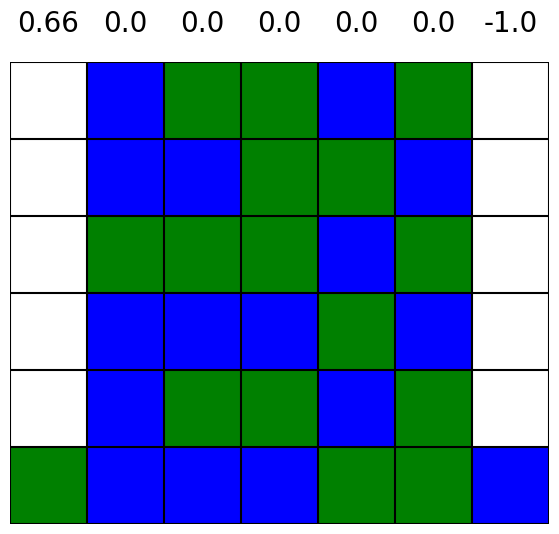

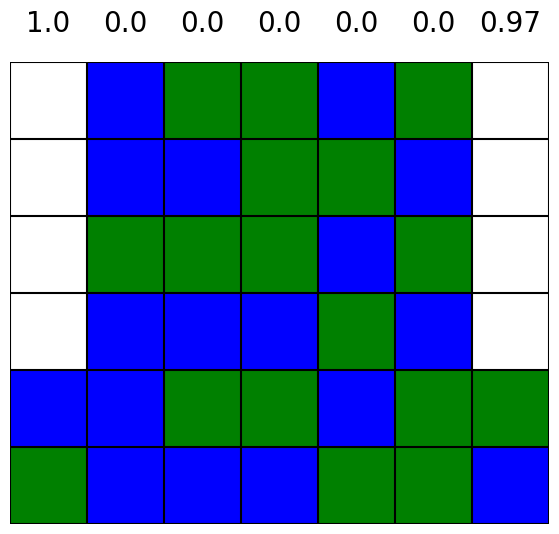

Win


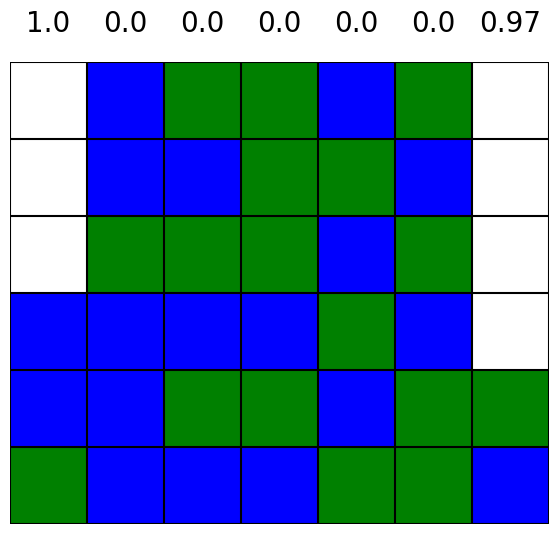

In [68]:
single_game()

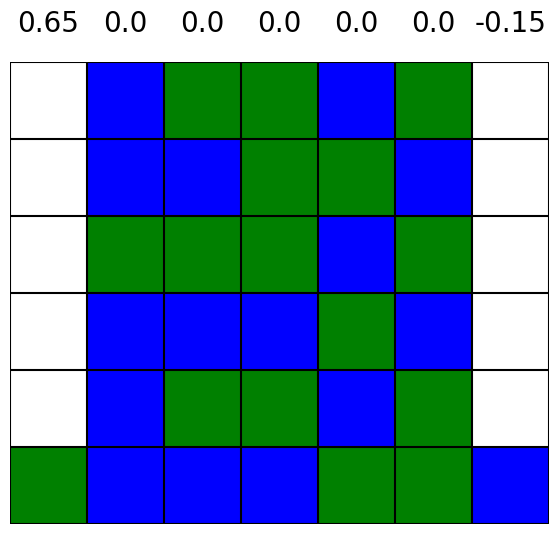

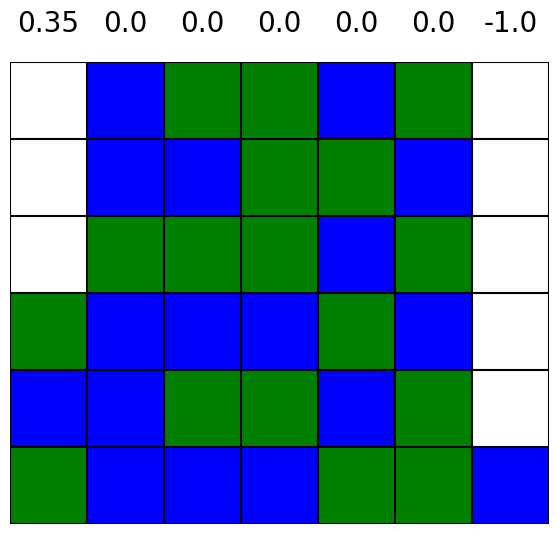

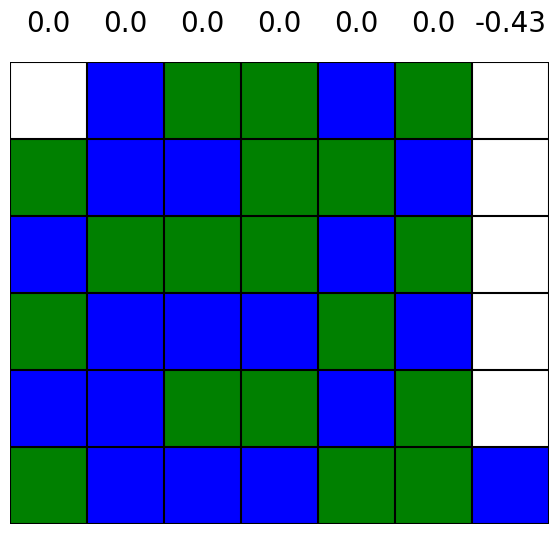

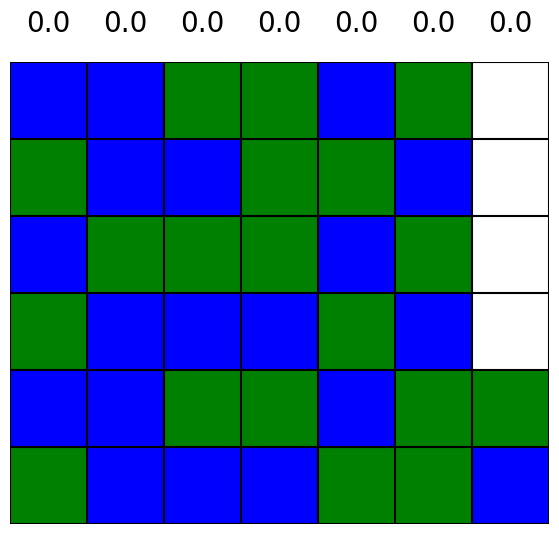

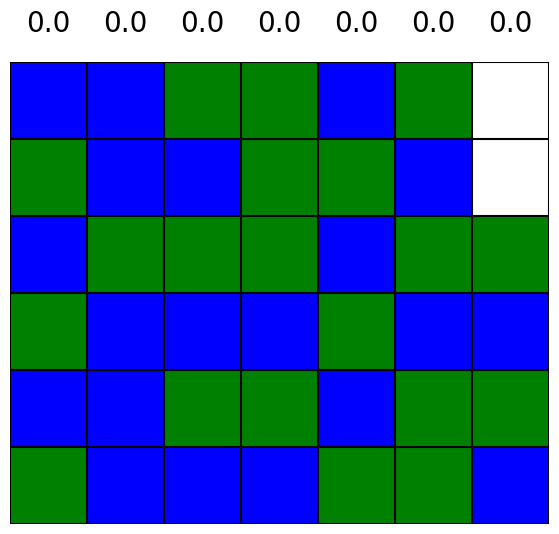

Draw


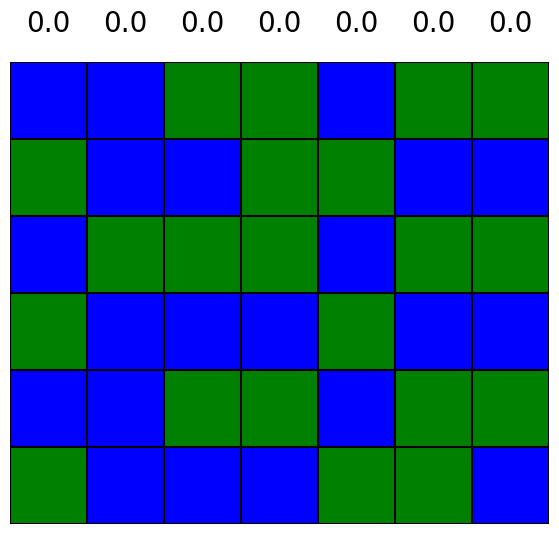

In [69]:
single_game()

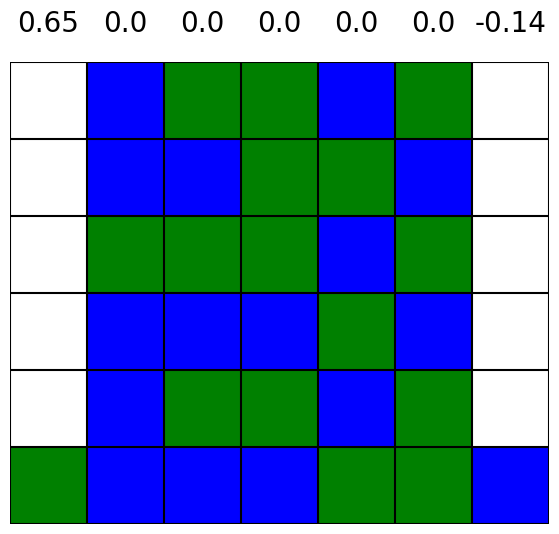

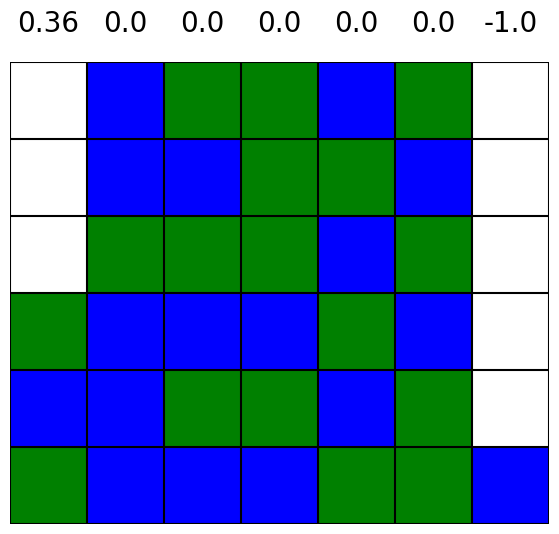

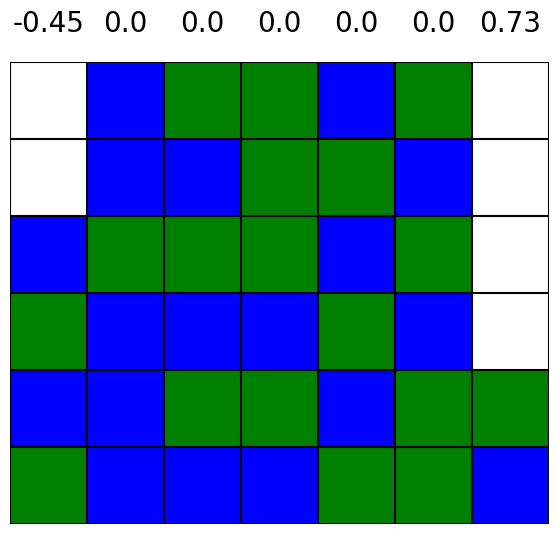

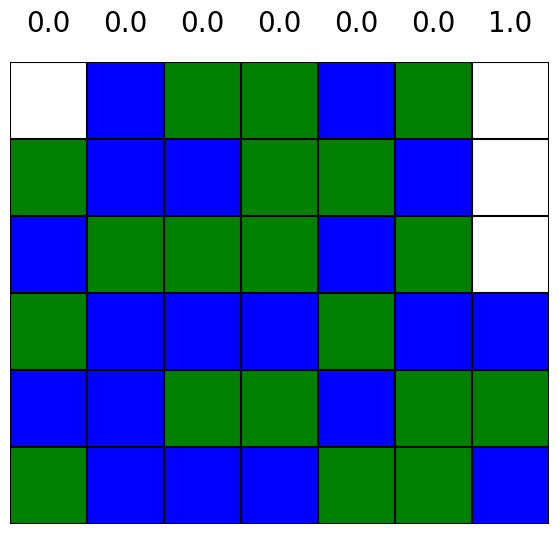

Win


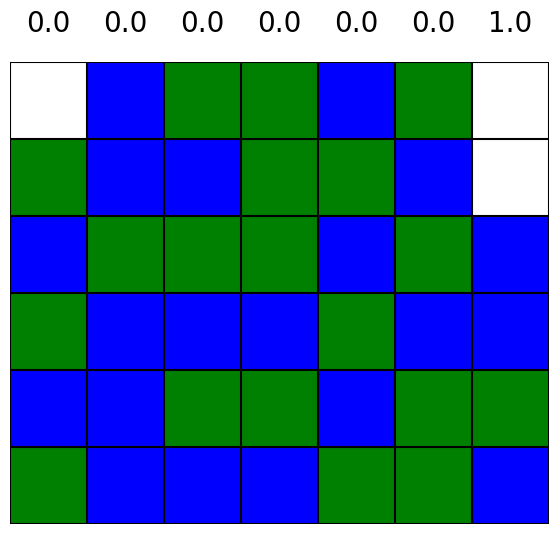

In [80]:
single_game()